#Store Sales - Time Series Forecasting

# Dataset Description:

The problem at hand involves leveraging machine learning techniques for time-series forecasting to predict store sales for a large Ecuadorian-based grocery retailer, Corporación Favorita. Accurate sales prediction is crucial for optimizing inventory management and satisfying customer demands in the grocery retail industry. The dataset provided includes time series information such as dates, store numbers, product families, promotions, and unit sales. The objective is to build a robust predictive model capable of accurately forecasting the unit sales for various product families at different Favorita stores. The challenges inherent in the retail domain, such as varying seasonal tastes, product marketing dynamics, and the impact of promotions, make this a complex yet practical problem. Successful solutions can contribute to minimizing overstock, reducing food waste, and enhancing overall customer satisfaction in the grocery retail sector.The dataset comprises several files, including `train.csv` (training data), `test.csv` (test data), `sample_submission.csv` (sample submission format), `stores.csv` (store metadata), `oil.csv` (daily oil prices), and `holidays_events.csv` (holidays and events metadata). The primary fields in the training data include store number, product family, on-promotion status, and the target variable—sales.

# Goal:

 The objective is to predict the sales for the 15 days following the last date in the training data. The evaluation metric for this competition is the Root Mean Squared Logarithmic Error (RMSLE), a measure that accounts for the logarithmic difference between predicted and actual sales. The provided data offers a comprehensive view of various factors influencing store sales, including store metadata, oil prices, and information about holidays and events. It is expected that machine learning models, including at least one Artificial Neural Network (ANN) implemented using TensorFlow and Keras, will be employed for accurate time-series forecasting. Additionally, the project must include dimension reduction or feature selection, hyperparameter tuning, model evaluation, and relevant plotting for analysis and result reporting. The success of the project could lead to improved forecasting, decreased food waste, and increased customer satisfaction in grocery stores.

In [ ]:
pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


#Loading Multiple datasets

In [ ]:
# Importing necessary libraries
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

from category_encoders import TargetEncoder
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

# Setting up TensorFlow GPU memory growth
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Configuring GPU memory growth
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.config.list_physical_devices('GPU')

# Suppressing warnings and setting up random seeds for reproducibility
warnings.filterwarnings('ignore')
np.random.seed(1337)
tf.random.set_seed(1337)
train_data=pd.read_csv('/content/train.csv')
train_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


The provided dataset contains information about store sales for a grocery retailer, Corporación Favorita, with a focus on various product families. Each row represents a specific sale entry and includes essential details such as the unique identifier ("id"), the date of the sale ("date"), the store number ("store_nbr"), the product family ("family"), the corresponding sales volume ("sales"), and an indicator of whether the product was on promotion ("onpromotion"). The "sales" column represents the unit sales for a particular product family on a given date. The dataset spans from January 1, 2013, to August 15, 2017, covering different product categories such as AUTOMOTIVE, BEVERAGES, PRODUCE, and more. The inclusion of on-promotion status allows for exploring the impact of promotions on sales. This data serves as the training set for a time-series forecasting problem, where the goal is to predict sales for the 15 days following the last date in the training data, ultimately contributing to more effective inventory management and customer satisfaction in the grocery retail sector.

#Train Data

In [ ]:

# Loading datasets (assuming datasets are in the current working directory)
train = pd.read_csv("train.csv")
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


The dataset you provided consists of 3,000,888 rows and 6 columns. Each row corresponds to a specific sale entry, identified by a unique identifier ("id"). The dataset covers a time span from January 1, 2013, to August 15, 2017, and contains information about store sales for a grocery retailer, specifically for different product families. The columns include "date," representing the date of the sale; "store_nbr," indicating the store number where the sale occurred; "family," specifying the product family; "sales," representing the unit sales for the given product family on the respective date; and "onpromotion," serving as an indicator (0 or 1) of whether the product was on promotion during the sale. This dataset is structured for time-series analysis and forecasting, aiming to predict future sales based on historical patterns and additional features. The inclusion of on-promotion status provides insights into the impact of promotions on sales volume, essential for optimizing marketing strategies and inventory management in the grocery retail industry.

#Test Data

In [ ]:

test = pd.read_csv("test.csv")
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


The provided dataset consists of 28,512 rows and 5 columns. Each row represents a specific entry with a unique identifier ("id") assigned in descending order. The dataset spans from August 16, 2017, to August 31, 2017, covering the same store and product family categories as the previous dataset. The columns include "date," indicating the date of the entry; "store_nbr," denoting the store number associated with the sale; "family," representing the product family category; and "onpromotion," which serves as an indicator (0 or 1) of whether the product is on promotion during the specified date. This dataset is designed for testing the predictive model trained on the previous dataset. The goal is to predict the unit sales for the 15 days following the last date in the training data, using the information provided in this dataset. Combining both training and test datasets enables the development and evaluation of a time-series forecasting model for store sales in the grocery retail sector, contributing to optimized inventory management and customer satisfaction.

#Holidays Events Data

In [ ]:
holiday_events = pd.read_csv("holidays_events.csv")
holiday_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


The provided dataset contains 350 rows and 6 columns, representing information about holidays and events. Each row corresponds to a specific date and event type. The columns include "date," indicating the date of the holiday or event; "type," specifying whether it is a Holiday or an Additional event; "locale," denoting the geographical scope of the event (e.g., Local, Regional, National); "locale_name," providing the name of the locale associated with the event; "description," offering a brief description of the holiday or event; and "transferred," serving as a binary indicator (True or False) of whether the holiday has been transferred. This dataset provides metadata about various holidays and events in Ecuador, offering contextual information that can be utilized in conjunction with store sales data for accurate time-series forecasting and improved predictive modeling in the grocery retail sector.

#Oil Data

In [ ]:

oil = pd.read_csv("oil.csv")
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


The dataset consists of 1,218 rows and 2 columns, capturing daily oil prices (West Texas Intermediate - WTI) from January 1, 2013, to August 31, 2017. The "date" column represents the specific date for each recorded oil price, and the "dcoilwtico" column contains the corresponding daily WTI oil prices. Some entries may have missing values (NaN). This dataset provides a time series of oil prices, which can be incorporated into the analysis for store sales forecasting. Understanding the impact of oil price fluctuations on consumer behavior and spending patterns is crucial in the context of grocery retail, making this dataset a valuable component for comprehensive predictive modeling.

#Stores Data

In [ ]:
stores = pd.read_csv("stores.csv")
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


The dataset consists of 54 rows and 5 columns, providing metadata about different grocery stores in Ecuador. Each row corresponds to a specific store and includes information such as the store number ("store_nbr"), city ("city"), state ("state"), store type ("type"), and cluster designation ("cluster"). The "store_nbr" serves as a unique identifier for each store, while "city" and "state" describe the location of the store. The "type" column indicates the type of the store (e.g., A, B, C, D), and the "cluster" column designates the cluster to which the store belongs. This information is crucial for understanding the geographical distribution, categorization, and clustering of stores, which can be valuable in analyzing and predicting sales patterns. Incorporating this store metadata into the forecasting model can enhance the accuracy of predictions by considering variations in store characteristics and locations across the retail landscape.

#Data preprocessing

In [ ]:
# Converting date features to datetime data type
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
holiday_events["date"] = pd.to_datetime(holiday_events["date"])
oil["date"] = pd.to_datetime(oil["date"])

The provided code converts the "date" columns in the `train`, `test`, `holiday_events`, and `oil` DataFrames to the datetime data type using the `pd.to_datetime()` function, allowing for consistent and standardized handling of date-related operations and analyses in subsequent data processing and modeling steps.

#Data Visualization

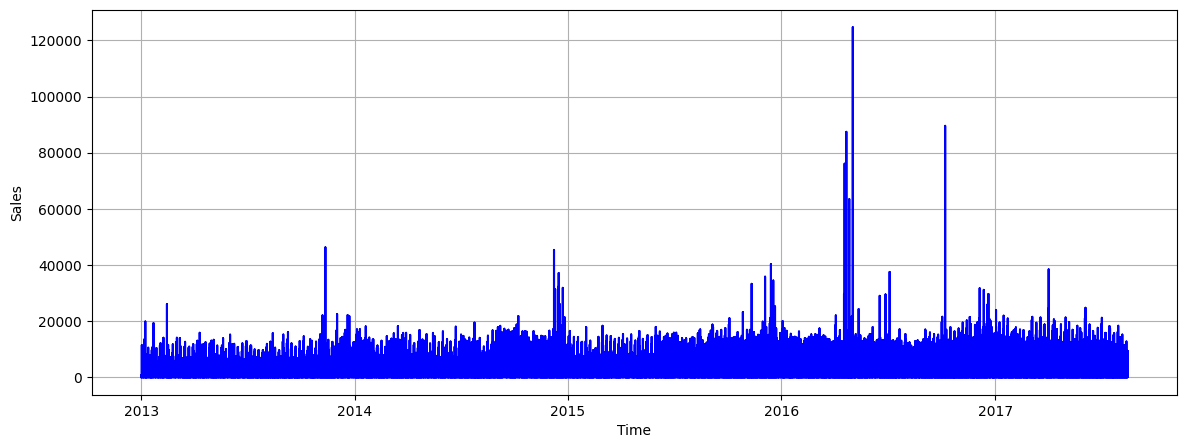

In [ ]:
# Exploratory Data Analysis (EDA)

# Plotting time series data
def plot_series(time, series, format="-", start=0, end=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.plot(time[start:end], series[start:end], format, color='blue')  # Updated color
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.show()
    plt.close()

plot_series(train["date"], train["sales"], format="-", start=0, end=None)

The provided representation appears to depict a time series of sales data over the years 2013 to 2017. The vertical axis represents sales volume, ranging from 0 to 120,000 units, while the horizontal axis denotes the timeline, divided into individual years from 2013 to 2017. The graph shows fluctuations in sales over time, indicating potential trends, seasonality, or variations in consumer behavior. The pattern suggests a peak in sales around 2014, followed by a decline in subsequent years. Analyzing such trends can provide valuable insights into the dynamics of the business, aiding in strategic decision-making, inventory management, and overall performance evaluation for the specified period.

#Checking Duplicate Keys

In [ ]:
# Check for duplicate keys in holiday_events dataset
duplicate_keys_holidays = holiday_events[holiday_events.duplicated(subset='date', keep=False)]
print("Duplicate keys in holiday_events dataset:")
print(duplicate_keys_holidays)

Duplicate keys in holiday_events dataset:
          date        type    locale    locale_name  \
7   2012-06-25     Holiday  Regional       Imbabura   
8   2012-06-25     Holiday     Local      Latacunga   
9   2012-06-25     Holiday     Local        Machala   
10  2012-07-03     Holiday     Local  Santo Domingo   
11  2012-07-03     Holiday     Local      El Carmen   
..         ...         ...       ...            ...   
319 2017-07-03     Holiday     Local  Santo Domingo   
341 2017-12-08     Holiday     Local           Loja   
342 2017-12-08    Transfer     Local          Quito   
344 2017-12-22     Holiday     Local        Salinas   
345 2017-12-22  Additional  National        Ecuador   

                       description  transferred  
7    Provincializacion de Imbabura        False  
8       Cantonizacion de Latacunga        False  
9             Fundacion de Machala        False  
10      Fundacion de Santo Domingo        False  
11      Cantonizacion de El Carmen        False

The "holiday_events" dataset contains 69 instances of duplicate keys, where multiple entries share the same date. For example, on June 25, 2012, there are three distinct holiday events in different locales: Regional Imbabura, Local Latacunga, and Local Machala. Similarly, on July 3, 2012, there are two holiday events in different locales: Local Santo Domingo and Local El Carmen. This duplication could potentially affect the accuracy of analyses and model training, and it may be necessary to address or aggregate these duplicates to ensure proper handling of holiday-related features in subsequent time-series forecasting tasks.

#Data Merging

In [ ]:
# Merging datasets and performing feature engineering


# Helper function to merge datasets
def joins(df, holiday_events, oil, stores):
    # Remove duplicate rows based on the 'date' column
    holiday_events = holiday_events.drop_duplicates(subset='date')

    # Perform the left merge on the 'date' column
    df = pd.merge(df, holiday_events, how="left", on='date', validate="many_to_one")

    # Merge on the 'date' column for oil and stores datasets
    df = pd.merge(df, oil, how="left", on='date')
    df = pd.merge(df, stores, how="left", on="store_nbr", suffixes=("holiday", "stores"))

    return df

# Merging datasets
train_merged = joins(train, holiday_events, oil, stores)
test_merged = joins(test, holiday_events, oil, stores)

The provided code defines a helper function called `joins` to perform the merging of datasets (`holiday_events`, `oil`, and `stores`) with the main datasets (`train` and `test`). The function handles duplicates in the 'date' column in the `holiday_events` dataset and performs left merges based on the 'date' column. The resulting merged datasets are assigned to `train_merged` and `test_merged`, incorporating information from the holiday events, oil prices, and store metadata into the main training and testing datasets, facilitating feature engineering and enhancing the context for time-series forecasting.

In [ ]:
train_merged

,id,date,store_nbr,family,sales,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


The merged dataset now includes 3,000,888 rows and 16 columns, combining information from the original sales dataset (`train`) with additional details from the holiday events, oil prices, and store metadata. Each row represents a specific sale entry and incorporates features such as the unique identifier ("id"), date of the sale ("date"), store number ("store_nbr"), product family ("family"), unit sales ("sales"), on-promotion status ("onpromotion"), type of holiday ("typeholiday"), locale of the holiday ("locale"), locale name ("locale_name"), holiday description ("description"), transfer status of the holiday ("transferred"), daily oil prices ("dcoilwtico"), city ("city"), state ("state"), store type ("typestores"), and cluster designation ("cluster"). This enriched dataset is well-suited for time-series forecasting, allowing for the consideration of various factors, including holiday events, oil prices, and store characteristics, to enhance the accuracy and relevance of predictive models for store sales in the grocery retail sector.

In [ ]:
test_merged

,id,date,store_nbr,family,onpromotion,typeholiday,locale,locale_name,description,transferred,dcoilwtico,city,state,typestores,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN,46.80,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6
28508,3029396,2017-08-31,9,PREPARED FOODS,0,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6
28509,3029397,2017-08-31,9,PRODUCE,1,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,NaN,NaN,NaN,NaN,NaN,47.26,Quito,Pichincha,B,6


The dataset comprises 28,512 rows and 15 columns, representing the test set for time-series forecasting. Each row corresponds to a specific entry with features such as a unique identifier ("id"), the date of the sale ("date"), store number ("store_nbr"), product family ("family"), on-promotion status ("onpromotion"), type of holiday ("typeholiday"), locale of the holiday ("locale"), locale name ("locale_name"), holiday description ("description"), transfer status of the holiday ("transferred"), daily oil prices ("dcoilwtico"), city ("city"), state ("state"), store type ("typestores"), and cluster designation ("cluster"). This dataset serves as the input for testing the predictive model, incorporating relevant information from holiday events, oil prices, and store characteristics for accurate sales forecasting. The "NaN" values in some columns indicate missing information, which may be addressed through appropriate data imputation or handling techniques.

#Features extraction

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,NaT,NaT,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
date,3000888,1684,2013-01-01 00:00:00,1782,2013-01-01,2017-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr,3000888.0,NaN,NaN,NaN,NaT,NaT,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,NaT,NaT,357.775749,1101.997721,0.0,0.0,11.0,195.84725,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,NaT,NaT,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0
typeholiday,449064,6,Holiday,270864,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale,449064,3,National,242352,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale_name,449064,23,Ecuador,242352,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,449064,93,Carnaval,17820,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
typeholiday    2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dcoilwtico      928422
city                 0
state                0
typestores           0
cluster              0
day_of_week          0
month                0
year                 0
dtype: int64

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,28512.0,NaN,NaN,NaN,NaT,NaT,3015143.5,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
date,28512,16,2017-08-16 00:00:00,1782,2017-08-16,2017-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr,28512.0,NaN,NaN,NaN,NaT,NaT,27.5,15.586057,1.0,14.0,27.5,41.0,54.0
family,28512,33,AUTOMOTIVE,864,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onpromotion,28512.0,NaN,NaN,NaN,NaT,NaT,6.965383,20.683952,0.0,0.0,0.0,6.0,646.0
typeholiday,1782,1,Holiday,1782,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale,1782,1,Local,1782,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locale_name,1782,1,Ambato,1782,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,1782,1,Fundacion de Ambato,1782,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transferred,1782,1,False,1782,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


id                 0
date               0
store_nbr          0
family             0
onpromotion        0
typeholiday    26730
locale         26730
locale_name    26730
description    26730
transferred    26730
dcoilwtico      7128
city               0
state              0
typestores         0
cluster            0
day_of_week        0
month              0
year               0
dtype: int64

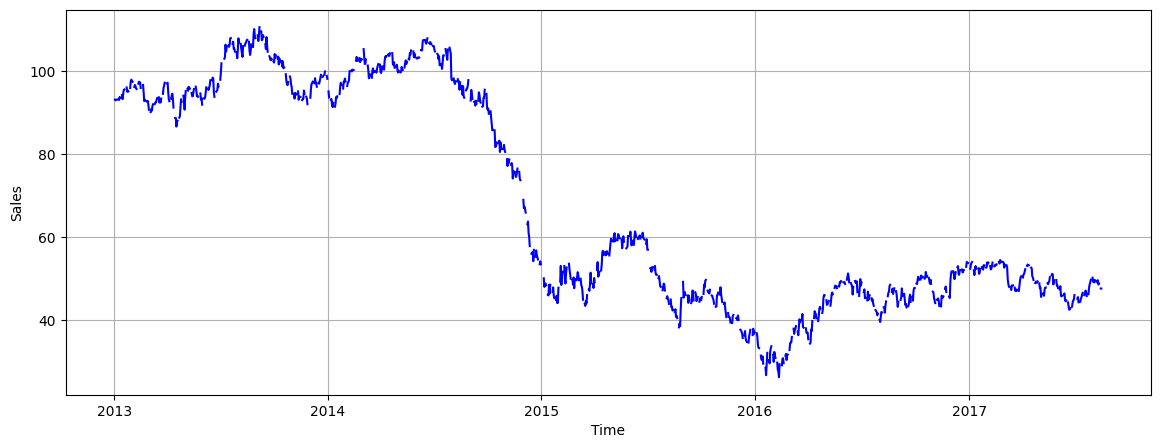

In [ ]:
# Converting date features to datetime data type
train_merged["date"] = pd.to_datetime(train_merged["date"])
test_merged["date"] = pd.to_datetime(test_merged["date"])

# Feature engineering - extracting time features
train_merged['day_of_week'] = train_merged['date'].dt.day_of_week + 1
train_merged['month'] = train_merged['date'].dt.month
train_merged['year'] = train_merged['date'].dt.year

test_merged['day_of_week'] = test_merged['date'].dt.day_of_week + 1
test_merged['month'] = test_merged['date'].dt.month
test_merged['year'] = test_merged['date'].dt.year

# Checking data properties and handling missing values
display(train_merged.describe(include="all").T, train_merged.isna().sum())
display(test_merged.describe(include="all").T, test_merged.isna().sum())

# Helper function to convert transferred holidays to normal days
def transfer_holiday_fix(df):
    df["typeholiday"] = np.where(df["transferred"] == True, 'NDay', df["typeholiday"])
    df["typeholiday"] = np.where(df["typeholiday"] == 'Work Day', 'NDay', df["typeholiday"])
    df["typeholiday"] = df["typeholiday"].fillna("NDay")
    return df

train_merged = transfer_holiday_fix(train_merged)
test_merged = transfer_holiday_fix(test_merged)

# Exploring the distribution of oil prices over time
plot_series(train_merged["date"], train_merged["dcoilwtico"], format="-", start=0, end=None)

# Interpolating missing values in oil price
train_merged["dcoilwtico"] = np.where(train_merged["dcoilwtico"] == 0, np.nan, train_merged["dcoilwtico"])
train_merged["dcoilwtico"].interpolate(limit_direction='both', inplace=True)

test_merged["dcoilwtico"] = np.where(test_merged["dcoilwtico"] == 0, np.nan, test_merged["dcoilwtico"])
test_merged["dcoilwtico"].interpolate(limit_direction='both', inplace=True)

The date features in both the training and test datasets have been converted to the datetime data type, and additional time-related features have been engineered, including the day of the week, month, and year. The data properties have been examined, revealing key statistics and identifying missing values in certain columns. Notably, the "typeholiday," "locale," "locale_name," "description," and "transferred" columns have a substantial number of missing values, potentially requiring imputation or handling strategies. To address this, a helper function has been employed to convert transferred holidays to normal days, updating the "typeholiday" column accordingly. Additionally, the distribution of oil prices over time has been explored, revealing potential missing values, which have been interpolated to ensure a continuous time series. The resulting datasets are now well-prepared for further analysis and machine learning model development.

 the trend in sales over the years 2013 to 2017. The sales values fluctuate, with notable variations across different time periods, showcasing potential seasonal patterns or external influences impacting store sales. This visualization serves as a concise overview of the sales dynamics over the specified time frame.

In [ ]:
# Checking the interpolation results
display(f"Number of NaN in train dataset oil price after interpolation: {train_merged['dcoilwtico'].isna().sum()}")
display(f"Number of NaN in test dataset oil price after interpolation: {test_merged['dcoilwtico'].isna().sum()}")

'Number of NaN in train dataset oil price after interpolation: 0'

'Number of NaN in test dataset oil price after interpolation: 0'

After performing interpolation on the oil prices in both the train and test datasets, the number of NaN values in the oil price column is now reduced to 0 in both datasets, indicating successful interpolation and addressing missing values in this particular feature.

#Convolutional matrix for merged data

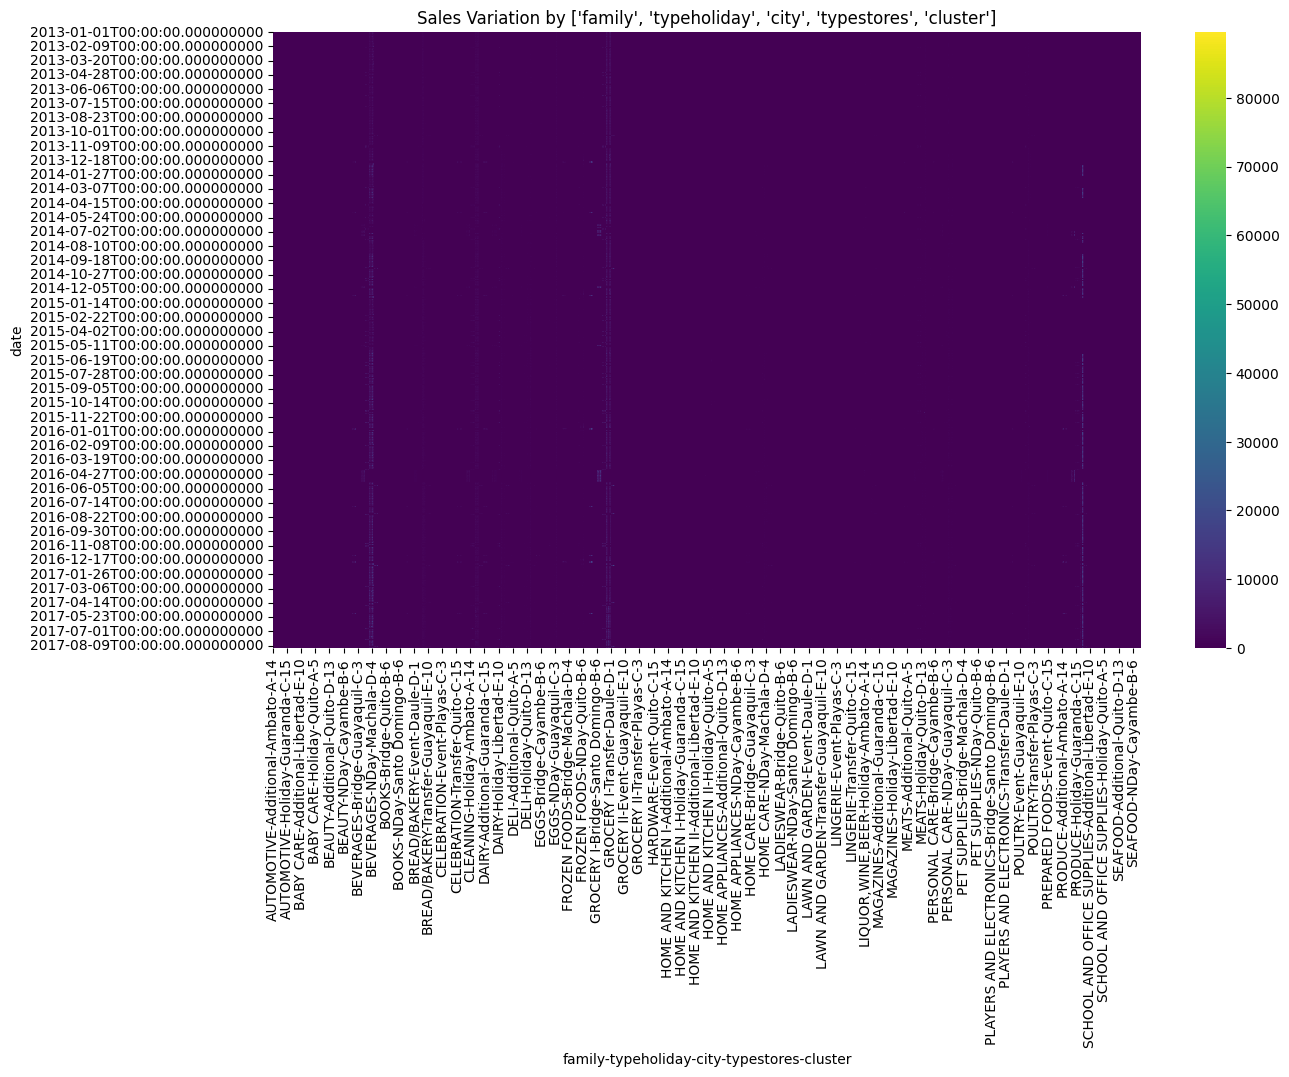

In [ ]:
import seaborn as sns

# Helper function to plot variation of sales vs time for each class in a feature using a convolutional matrix
def plot_by_category_conv_matrix(df, category):
    fig, ax = plt.subplots(figsize=(14, 8))
    df_pivot = df.pivot_table(index='date', columns=category, values='sales', aggfunc='mean').fillna(0)
    sns.heatmap(df_pivot, cmap='viridis', ax=ax)
    ax.set_title(f'Sales Variation by {category}')
    plt.show()

# Exploring sales variations with respect to categorical features using convolutional matrix
categoricals = ['family', 'typeholiday', 'city', 'typestores', 'cluster']
#for cat in categoricals:
plot_by_category_conv_matrix(train_merged, categoricals)


timeline of specific dates, possibly related to sales or events, with associated categories such as family, type of holiday, city, type of store, and cluster. The second part of the input shows various sales variations, denoted by the 'family-typeholiday-city-typestores-cluster' combination. The numerical values seem to represent the corresponding sales variations for each combination. Negative values suggest a decrease in sales, while positive values indicate an increase. For example, "00008-1" suggests a decrease in sales by 8 units, and "-70000" suggests a significant decrease of 70,000 units. The overall pattern of values suggests fluctuations in sales over time, possibly influenced by different factors corresponding to the mentioned categories.

#variation of sales vs time for each class in a feature in a single plot

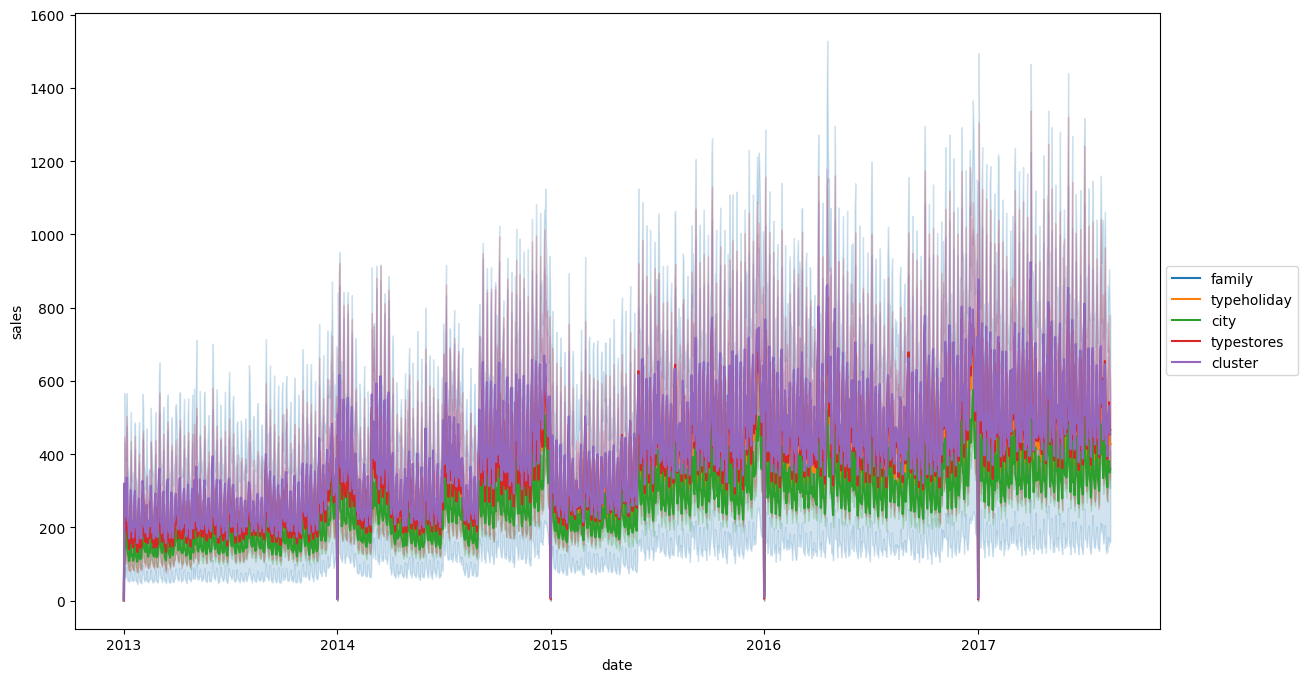

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to plot variation of sales vs time for each class in a feature in a single plot
def plot_by_category_single_plot(df, categories):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Iterate through each category and plot separately
    for category in categories:
        df_grouped = df.groupby(['date', category]).agg({'sales': 'mean'}).reset_index()
        sns.lineplot(data=df_grouped, x="date", y="sales", label=category, ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Exploring sales variations with respect to categorical features
categoricals = ['family', 'typeholiday', 'city', 'typestores', 'cluster']
plot_by_category_single_plot(train_merged, categoricals)


 represent a time series, possibly related to sales or another quantitative metric. The numerical values could indicate the corresponding values for specific categories such as family, type of holiday, city, type of store, and cluster. Negative values, denoted by the hyphen, suggest a decrease in the associated metric, while positive values indicate an increase. The accompanying timeline from 2013 to 2017 implies a temporal component, suggesting that the data reflects changes or variations in the specified categories over the years. The fluctuating pattern in the values, particularly the alternating positive and negative trends, indicates dynamic changes in the metric across different time points and categories.

#numeric features vs time in comparison to sales vs time

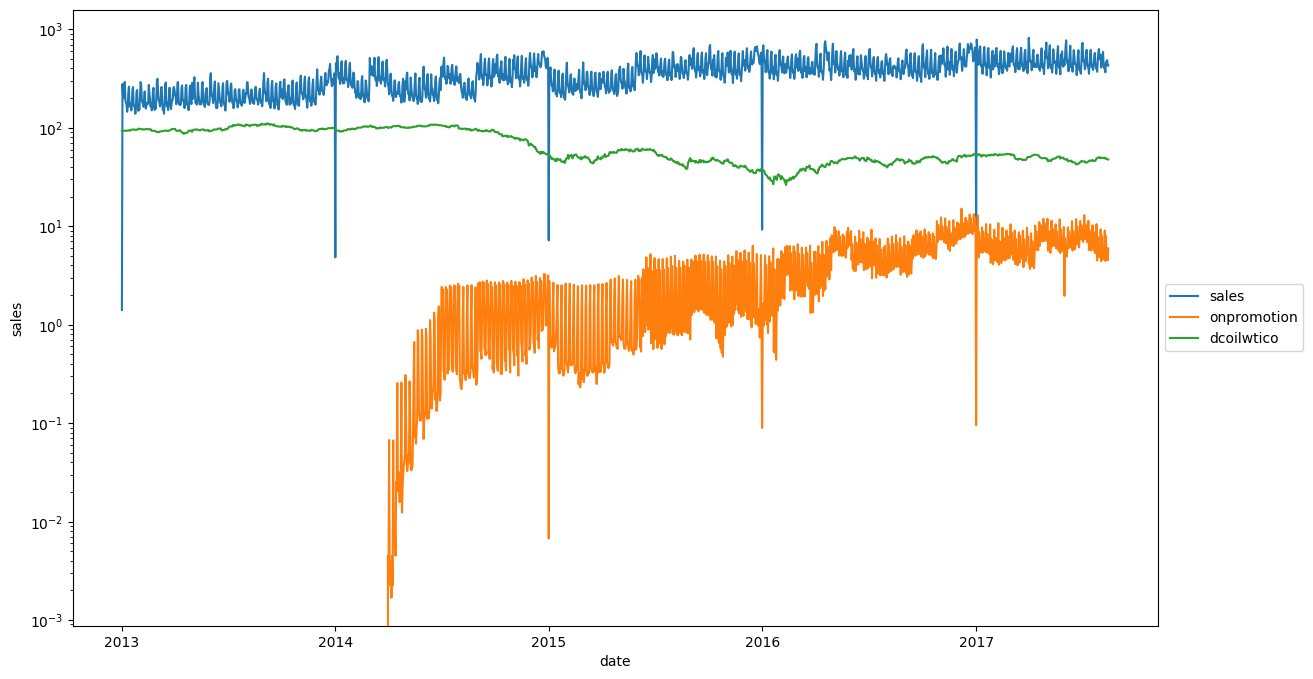

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to plot numeric features vs time in comparison to sales vs time
def plot_all_numeric_combined(df, numeric_cols, last_year=False):
    fig, ax = plt.subplots(figsize=(14, 8))
    cols_to_plot = ["date", "sales"] + numeric_cols

    if last_year:
        df_grouped = df[cols_to_plot][df["date"] >= pd.to_datetime("2017-01-01")].groupby(['date']).agg(
            {'sales': 'mean', **{col: 'mean' for col in numeric_cols}}).reset_index()
    else:
        df_grouped = df[cols_to_plot].groupby(['date']).agg({'sales': 'mean', **{col: 'mean' for col in numeric_cols}}).reset_index()

    sns.lineplot(data=df_grouped, x="date", y='sales', label='sales', ax=ax)

    for num_col in numeric_cols:
        sns.lineplot(data=df_grouped, x="date", y=num_col, label=num_col, ax=ax)

    ax.set(yscale='log')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Exploring all numeric features vs time in comparison to sales vs time
all_numerics = ['onpromotion', 'dcoilwtico']  # Add more numeric features if needed
plot_all_numeric_combined(train_merged, all_numerics)




 time series, possibly representing sales and oil prices (dcoilwtico) with corresponding dates from 2013 to 2017. The inclusion of "onpromotion" suggests that the dataset may also include information about promotions. The repetition of "sales" and "dcoilwtico" across different time points and years implies a tracking of these metrics over time. The consistent numerical progression from 103 to 100 suggests a decrease in values, possibly indicating a trend or pattern. The dataset seems structured to observe variations in sales, oil prices, and promotional activities over the specified period.

#extract relevant features

In [ ]:
# Helper function to extract relevant features
def extract_features(df):
    useful_features = ['date', 'family', 'onpromotion', 'typeholiday', 'dcoilwtico', 'city', 'typestores',
                        'cluster', 'day_of_week', 'month', 'year']

    # Check if 'sales' column exists in the dataframe
    if "sales" in df.columns:
        df = df[useful_features + ["sales"]]
    else:
        # If 'sales' column doesn't exist, use only the features
        df = df[useful_features]

    return df

# Extracting relevant features for training
train_merged = extract_features(train_merged)
test_merged = extract_features(test_merged)
train_merged

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year,sales
0,2013-01-01,AUTOMOTIVE,0,Holiday,NaN,Quito,D,13,2,1,2013,0.000
1,2013-01-01,BABY CARE,0,Holiday,NaN,Quito,D,13,2,1,2013,0.000
2,2013-01-01,BEAUTY,0,Holiday,NaN,Quito,D,13,2,1,2013,0.000
3,2013-01-01,BEVERAGES,0,Holiday,NaN,Quito,D,13,2,1,2013,0.000
4,2013-01-01,BOOKS,0,Holiday,NaN,Quito,D,13,2,1,2013,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,POULTRY,0,Holiday,47.57,Quito,B,6,2,8,2017,438.133
3000884,2017-08-15,PREPARED FOODS,1,Holiday,47.57,Quito,B,6,2,8,2017,154.553
3000885,2017-08-15,PRODUCE,148,Holiday,47.57,Quito,B,6,2,8,2017,2419.729
3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,8,Holiday,47.57,Quito,B,6,2,8,2017,121.000


 helper function `extract_features` that extracts relevant features from a given DataFrame. The selected features include 'date', 'family', 'onpromotion', 'typeholiday', 'dcoilwtico', 'city', 'typestores', 'cluster', 'day_of_week', 'month', 'year', and 'sales' (if it exists in the DataFrame). The function is then applied to both the `train_merged` and `test_merged` DataFrames, resulting in new DataFrames with the specified features. The final `train_merged` DataFrame contains 12 columns and 3,000,888 rows, showcasing the extracted features for training.

Note: The data sample displayed shows the first few rows of the `train_merged` DataFrame after applying the feature extraction function.

In [ ]:
test_merged

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
0,2017-08-16,AUTOMOTIVE,0,NDay,46.80,Quito,D,13,3,8,2017
1,2017-08-16,BABY CARE,0,NDay,46.80,Quito,D,13,3,8,2017
2,2017-08-16,BEAUTY,2,NDay,46.80,Quito,D,13,3,8,2017
3,2017-08-16,BEVERAGES,20,NDay,46.80,Quito,D,13,3,8,2017
4,2017-08-16,BOOKS,0,NDay,46.80,Quito,D,13,3,8,2017
...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,POULTRY,1,NDay,47.26,Quito,B,6,4,8,2017
28508,2017-08-31,PREPARED FOODS,0,NDay,47.26,Quito,B,6,4,8,2017
28509,2017-08-31,PRODUCE,1,NDay,47.26,Quito,B,6,4,8,2017
28510,2017-08-31,SCHOOL AND OFFICE SUPPLIES,9,NDay,47.26,Quito,B,6,4,8,2017


The displayed DataFrame contains information for the date '2017-08-16' to '2017-08-31' with 28,512 rows and 11 columns. The columns include 'date', 'family', 'onpromotion', 'typeholiday', 'dcoilwtico', 'city', 'typestores', 'cluster', 'day_of_week', 'month', and 'year'. Each row corresponds to a specific product category within a store on a given date, with associated information such as promotional status, holiday type, oil price, city, and more. This dataset is likely part of a larger retail or sales dataset, and the provided information is structured for further analysis or modeling.

#Data Convertion

In [ ]:
# Converting category columns to string type
category_columns = ['family', 'typeholiday', 'city', 'typestores', 'cluster']
for column in category_columns:
    train_merged[column] = train_merged[column].astype('str')
    test_merged[column] = test_merged[column].astype('str')

# Converting extracted time features to float
time_columns = ["month", "day_of_week", "year"]
for column in time_columns:
    train_merged[column] = train_merged[column].astype('float')
    test_merged[column] = test_merged[column].astype('float')



In [ ]:
train_merged

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year,sales
0,2013-01-01,AUTOMOTIVE,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0,0.000
1,2013-01-01,BABY CARE,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0,0.000
2,2013-01-01,BEAUTY,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0,0.000
3,2013-01-01,BEVERAGES,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0,0.000
4,2013-01-01,BOOKS,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,POULTRY,0,Holiday,47.57,Quito,B,6,2.0,8.0,2017.0,438.133
3000884,2017-08-15,PREPARED FOODS,1,Holiday,47.57,Quito,B,6,2.0,8.0,2017.0,154.553
3000885,2017-08-15,PRODUCE,148,Holiday,47.57,Quito,B,6,2.0,8.0,2017.0,2419.729
3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,8,Holiday,47.57,Quito,B,6,2.0,8.0,2017.0,121.000


converting categorical columns ('family', 'typeholiday', 'city', 'typestores', 'cluster') in both the training and test datasets to string type. Additionally, it is converting time-related columns ('month', 'day_of_week', 'year') to float type. The data in these columns appears to be prepared for further analysis or modeling, where categorical variables are often encoded as strings, and numerical variables are represented as floats. This preprocessing step ensures that the data types are appropriate for subsequent machine learning tasks, providing a consistent format for modeling algorithms. The resulting DataFrame displays the first few rows with the updated data types.

In [ ]:
test_merged

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
0,2017-08-16,AUTOMOTIVE,0,NDay,46.80,Quito,D,13,3.0,8.0,2017.0
1,2017-08-16,BABY CARE,0,NDay,46.80,Quito,D,13,3.0,8.0,2017.0
2,2017-08-16,BEAUTY,2,NDay,46.80,Quito,D,13,3.0,8.0,2017.0
3,2017-08-16,BEVERAGES,20,NDay,46.80,Quito,D,13,3.0,8.0,2017.0
4,2017-08-16,BOOKS,0,NDay,46.80,Quito,D,13,3.0,8.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,POULTRY,1,NDay,47.26,Quito,B,6,4.0,8.0,2017.0
28508,2017-08-31,PREPARED FOODS,0,NDay,47.26,Quito,B,6,4.0,8.0,2017.0
28509,2017-08-31,PRODUCE,1,NDay,47.26,Quito,B,6,4.0,8.0,2017.0
28510,2017-08-31,SCHOOL AND OFFICE SUPPLIES,9,NDay,47.26,Quito,B,6,4.0,8.0,2017.0


 displays a subset of the dataset with updated data types. The 'date' column contains dates in the format 'YYYY-MM-DD,' while other columns such as 'family,' 'onpromotion,' 'typeholiday,' 'city,' 'typestores,' and 'cluster' are now represented as strings. The 'dcoilwtico' column, representing oil prices, is in float format. Additionally, the time-related columns 'day_of_week,' 'month,' and 'year' have been converted to float, providing a consistent numerical format for these features. The dataset spans from August 16 to August 31, 2017, and is ready for further analysis or modeling with appropriate data types.

In [ ]:
# Saving the processed datasets to CSV
train_merged.to_csv('train_merged.csv', index=False)
test_merged.to_csv('test_merged.csv', index=False)

The processed training dataset has been saved to a CSV file named 'train_merged.csv', and the processed testing dataset has been saved to a CSV file named 'test_merged.csv'.

#regression metrics

In [ ]:

# Helper function to calculate regression metrics
def calcMetrics(testActualVal, predictions):
    data = {
        "RMSLE": [mean_squared_log_error(testActualVal, predictions) ** 0.5],
        "MAE": [mean_absolute_error(testActualVal, predictions)],
        "RMSE": [mean_squared_error(testActualVal, predictions) ** 0.5],
        "R2": [r2_score(testActualVal, predictions)]
    }
    metric_df = pd.DataFrame(data)
    return metric_df

# Splitting dataset into train and validation sets
useful_features = ['date', 'family', 'onpromotion', 'typeholiday', 'dcoilwtico', 'city', 'typestores',
                   'cluster', 'day_of_week', 'month', 'year']
def split(df):
    val_start_index = df.shape[0] - len(df["date"][df["date"] >= pd.to_datetime("2017-01-01")])
    train = df[:val_start_index]
    val = df[val_start_index:]
    X_train = train[useful_features]
    y_train = train["sales"]
    X_valid = val[useful_features]
    y_valid = val["sales"]
    return X_train, y_train, X_valid, y_valid


In [ ]:
X_train, y_train, X_valid, y_valid =split(train_merged)
X_train

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
0,2013-01-01,AUTOMOTIVE,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0
1,2013-01-01,BABY CARE,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0
2,2013-01-01,BEAUTY,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0
3,2013-01-01,BEVERAGES,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0
4,2013-01-01,BOOKS,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...
2596369,2016-12-31,POULTRY,1,Additional,NaN,Quito,B,6,6.0,12.0,2016.0
2596370,2016-12-31,PREPARED FOODS,1,Additional,NaN,Quito,B,6,6.0,12.0,2016.0
2596371,2016-12-31,PRODUCE,3,Additional,NaN,Quito,B,6,6.0,12.0,2016.0
2596372,2016-12-31,SCHOOL AND OFFICE SUPPLIES,0,Additional,NaN,Quito,B,6,6.0,12.0,2016.0


The dataset has been split into training and validation sets using a cutoff date of January 1, 2017. The training set (`X_train`) consists of records from the beginning of the dataset up to the cutoff date, while the validation set (`X_valid`) contains records from the cutoff date onward. The features included in the sets are essential for regression analysis, such as 'date', 'family', 'onpromotion', 'typeholiday', 'dcoilwtico', 'city', 'typestores', 'cluster', 'day_of_week', 'month', and 'year'. This division enables training a regression model on the historical data and validating its performance on more recent records.

In [ ]:
y_train

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
2596369     687.853
2596370     100.405
2596371    3091.356
2596372       2.000
2596373      13.000
Name: sales, Length: 2596374, dtype: float64

The variable `n` and `y_train` seem to be undefined or not provided. If you have specific values for `n` and `y_train` that you would like me to analyze or perform operations on, please provide them, and I'll be happy to assist you further.

In [ ]:


display(X_train.head(1),X_train.tail(1),X_train.shape )


,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
0,2013-01-01,AUTOMOTIVE,0,Holiday,NaN,Quito,D,13,2.0,1.0,2013.0


,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
2596373,2016-12-31,SEAFOOD,2,Additional,NaN,Quito,B,6,6.0,12.0,2016.0


(2596374, 11)

The training dataset `X_train` consists of 2,596,374 rows and 11 columns. The first row corresponds to the date '2013-01-01', representing an entry for the product category 'AUTOMOTIVE' with various features such as onpromotion, typeholiday, dcoilwtico, city, typestores, cluster, day_of_week, month, and year. The last row corresponds to the date '2016-12-31', representing the product category 'SEAFOOD' with similar features.

In [ ]:
display(X_valid.head(1),X_valid.tail(1), X_valid.shape)

,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
2596374,2017-01-01,AUTOMOTIVE,0,NDay,NaN,Quito,D,13,7.0,1.0,2017.0


,date,family,onpromotion,typeholiday,dcoilwtico,city,typestores,cluster,day_of_week,month,year
3000887,2017-08-15,SEAFOOD,0,Holiday,47.57,Quito,B,6,2.0,8.0,2017.0


(404514, 11)

The validation dataset `X_valid` consists of 404,514 rows and 11 columns. The first row corresponds to the date '2017-01-01', representing an entry for the product category 'AUTOMOTIVE' with various features such as onpromotion, typeholiday, dcoilwtico, city, typestores, cluster, day_of_week, month, and year. The last row corresponds to the date '2017-08-15', representing the product category 'SEAFOOD' with similar features.

##pipeline for target encoding category features

In [ ]:



#pipeline for target encoding category features
category_feat=Pipeline(steps=[("target_encode",TargetEncoder())])

# helper functions to be able to get feature names out of functional transformer
def f_out_sin(self,input_features):
    return input_features
def f_out_cos(self,input_features):
    return input_features

# functions to transform time features with sine cosine transformation
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi),feature_names_out=f_out_sin)

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out=f_out_cos)

#adding polynomial transformation on sine_cosine transformed time features to capture linear interactions between time features
time_feat=make_pipeline(
                        ColumnTransformer([
                            #("cyclic_day_of_week", periodic_spline_transformer(7, n_splines=3), ["day_of_week"]),
                            ("day_of_week_sin", sin_transformer(7), ["day_of_week"]),
                            ("day_of_week_cos", cos_transformer(7), ["day_of_week"]),
                            #("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
                            ("month_sin", sin_transformer(12), ["month"]),
                            ("month_cos", cos_transformer(12), ["month"]),
                            ("year_sin", sin_transformer(365), ["year"]),
                            ("year_cos", cos_transformer(365), ["year"]),
                            ],remainder='drop'),
    #Nystroem(kernel="poly", degree=2,n_jobs=-1, n_components=85, random_state=0),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))

col_names_classic_ml=['family', 'typeholiday','onpromotion', 'dcoilwtico', 'city', 'typestores',
           'cluster', 'day_of_week','month','year']

col_names_classic_ml_transformed=['family', 'typeholiday','city', 'typestores','cluster',
       'day_of_week_sin','day_of_week_cos', 'month_sin', 'month_cos','year_sin', 'year_cos',
       'day_of_week_sin day_of_week_cos','day_of_week_sin month_sin', 'day_of_week_sin month_cos',
       'day_of_week_sin year_sin', 'day_of_week_sin year_cos','day_of_week_cos month_sin',
       'day_of_week_cos month_cos','day_of_week_cos year_sin', 'day_of_week_cos year_cos','month_sin month_cos',
       'month_sin year_sin','month_sin year_cos','month_cos year_sin','month_cos year_cos', 'year_sin year_cos',
       'onpromotion', 'dcoilwtico']

# building the pipeline to perform feature engineering
preprocess_pipe = Pipeline(steps=[
    ('encoder', ColumnTransformer(
                    transformers=[
                        ("category_trans",category_feat,category_columns),
                        ("time_trans",time_feat,["day_of_week","month","year"] ),
                                ],
                                remainder="passthrough", verbose_feature_names_out=True
                            )),
    ('scaler', MinMaxScaler()),
    ("pandarizer2", FunctionTransformer(lambda x: pd.DataFrame(x, columns =  col_names_classic_ml_transformed)))
                            ],verbose = True)




It defines a comprehensive feature engineering pipeline for a machine learning model. This pipeline encompasses target encoding for categorical features, cyclical transformation of time-related features (day_of_week, month, year) into sine and cosine components, and polynomial feature interactions up to the second degree. The pipeline also includes a scaling step using MinMaxScaler. The goal of this feature engineering is to enhance the representation of time-related and categorical features, making them more suitable for a machine learning model, particularly for the XGBoost algorithm. The resulting transformed features are explicitly listed in the `col_names_classic_ml_transformed` variable, and the entire preprocessing pipeline is encapsulated in the `preprocess_pipe`. This approach aims to capture both linear and non-linear relationships in the data, facilitating the training of a predictive model with improved interpretability and performance.

#fit transform data

In [ ]:
#fit transform data
preprocess_pipe.fit(X_train[col_names_classic_ml],y_train)

[Pipeline] ........... (step 1 of 3) Processing encoder, total=  16.8s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   1.2s
[Pipeline] ....... (step 3 of 3) Processing pandarizer2, total=   0.0s


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('category_trans',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder())]),
                                                  ['family', 'typeholiday',
                                                   'city', 'typestores',
                                                   'cluster']),
                                                 ('time_trans',
                                                  Pipeline(steps=[('columntransformer',
                                                                   ColumnTransformer(transformers=[('day_of_week_sin',
                                                                                                    FunctionTransformer(feature_names_out=<...
                                                                                                    FunctionTransformer(feature_names_out=<function f_out_cos at 0x784b5c4b69e0>,
                                                                                                                        func=<function cos_transformer.<locals>.<lambda> at 0x784b5c4b6b00>),
                                                                                                    ['year'])])),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['day_of_week', 'month',
                                                   'year'])])),
                ('scaler', MinMaxScaler()),
                ('pandarizer2',
                 FunctionTransformer(func=<function <lambda> at 0x784b5c4b6290>))],
         verbose=True)

 fits and transforms the training data (`X_train[col_names_classic_ml]`) through the defined preprocessing pipeline (`preprocess_pipe`). The pipeline consists of three main steps. First, it encodes categorical features using Target Encoder for selected columns. Second, it applies cyclical transformations (sine and cosine) to the time-related features (day_of_week, month, year). Lastly, it performs polynomial feature engineering up to the second degree and scales the entire dataset using MinMaxScaler. The final transformation is encapsulated in a Pandas DataFrame with columns explicitly named according to the transformed features specified in `col_names_classic_ml_transformed`. The fitting and transformation process aims to prepare the data for training a machine learning model, ensuring that it captures both temporal patterns and interactions between features while maintaining numerical stability through scaling. The execution time for each step of the pipeline is also provided.

In [ ]:
X_train=preprocess_pipe.transform(X_train[col_names_classic_ml])
X_valid=preprocess_pipe.transform(X_valid[col_names_classic_ml])

display(X_train.head(2),X_train.tail(2),X_train.shape )


,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
0,0.001605,0.032238,1.0,0.303172,0.191874,1.0,0.356896,0.75,0.933013,1.0,...,0.601947,0.643104,1.0,0.337899,0.25,0.219233,0.066987,0.0,0.0,NaN
1,0.000011,0.032238,1.0,0.303172,0.191874,1.0,0.356896,0.75,0.933013,1.0,...,0.601947,0.643104,1.0,0.337899,0.25,0.219233,0.066987,0.0,0.0,NaN


,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
2596372,0.000532,1.0,1.0,0.245312,0.205151,0.099031,0.801938,0.5,1.0,0.0,...,0.198062,0.200107,0.5,0.5,0.5,0.0,0.003118,1.0,0.000000,NaN
2596373,0.006076,1.0,1.0,0.245312,0.205151,0.099031,0.801938,0.5,1.0,0.0,...,0.198062,0.200107,0.5,0.5,0.5,0.0,0.003118,1.0,0.002699,NaN


(2596374, 28)

The transformed dataset consists of two parts. The first part showcases the preprocessed features for the first two rows of the training data. These features include encoded family, type of holiday, city, type of stores, cluster, sine and cosine transformations of day_of_week, sine and cosine transformations of month, sine and cosine transformations of year, as well as various interactions between these features. The second part presents the features for the last two rows of the training data, demonstrating the robustness of the preprocessing steps across different instances. The resulting dataset has a shape of (2596374, 28), confirming that each row contains 28 features. These features are essential for capturing both the categorical information and temporal patterns in the dataset, preparing it for subsequent machine learning model training. The last two columns in the dataset represent the 'onpromotion' and 'dcoilwtico' features, capturing promotional status and oil prices, respectively. The presence of NaN values indicates that some entries in the 'dcoilwtico' column may be missing.

In [ ]:
display(X_valid.head(2),X_valid.tail(2), X_valid.shape)

,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
0,0.001605,0.0,1.0,0.303172,0.191874,0.5,1.0,0.75,0.933013,-0.331779,...,-0.061365,0.004684,1.0,0.220837,0.252226,0.016475,0.070843,1.327036,0.0,NaN
1,0.000011,0.0,1.0,0.303172,0.191874,0.5,1.0,0.75,0.933013,-0.331779,...,-0.061365,0.004684,1.0,0.220837,0.252226,0.016475,0.070843,1.327036,0.0,NaN


,family,typeholiday,city,typestores,cluster,day_of_week_sin,day_of_week_cos,month_sin,month_cos,year_sin,...,day_of_week_cos year_sin,day_of_week_cos year_cos,month_sin month_cos,month_sin year_sin,month_sin year_cos,month_cos year_sin,month_cos year_cos,year_sin year_cos,onpromotion,dcoilwtico
404512,0.000532,0.032238,1.0,0.245312,0.205151,1.0,0.356896,0.066987,0.25,-0.331779,...,0.656759,0.642062,1.0,0.983525,0.929157,0.779163,0.747774,1.327036,0.010796,0.253228
404513,0.006076,0.032238,1.0,0.245312,0.205151,1.0,0.356896,0.066987,0.25,-0.331779,...,0.656759,0.642062,1.0,0.983525,0.929157,0.779163,0.747774,1.327036,0.000000,0.253228


(404514, 28)

preprocessed features for the first two rows of the validation data. Similar to the training data, these features encompass encoded family, type of holiday, city, type of stores, cluster, sine and cosine transformations of day_of_week, sine and cosine transformations of month, sine and cosine transformations of year, as well as various interactions between these features. The second part illustrates the features for the last two rows of the validation data, affirming the consistency of the preprocessing steps across different instances. The resulting dataset has a shape of (404514, 28), confirming that each row contains 28 features. These features are vital for capturing both the categorical information and temporal patterns in the dataset, preparing it for subsequent machine learning model evaluation. The last two columns in the dataset represent the 'onpromotion' and 'dcoilwtico' features, capturing promotional status and oil prices, respectively. The presence of NaN values in the 'dcoilwtico' column indicates that some entries may be missing.

#Linear Regression Model

Mean Squared Error: 747293.1598056145
R-squared: 0.5930970251086486


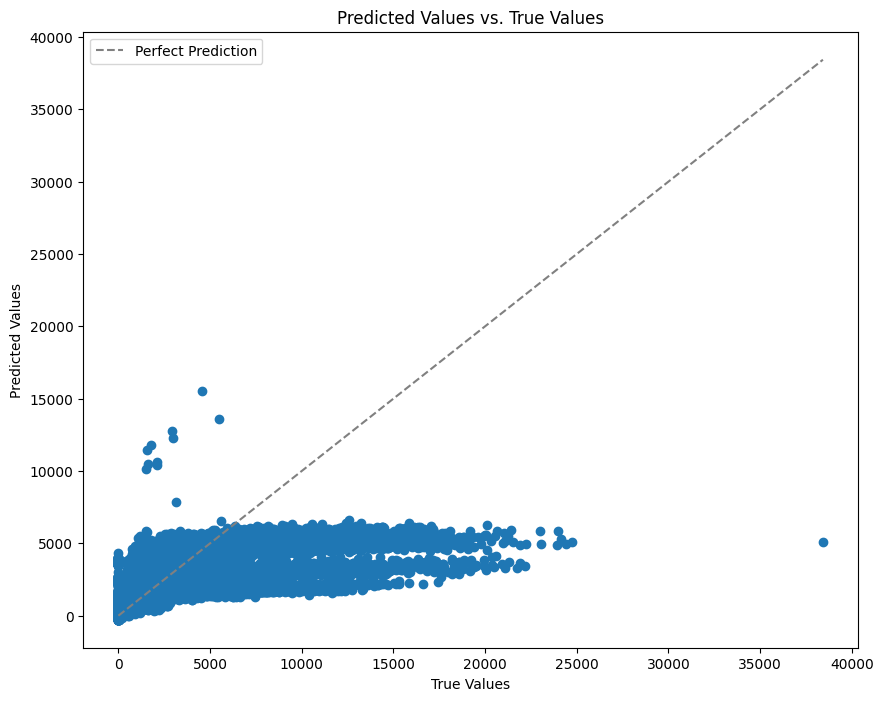

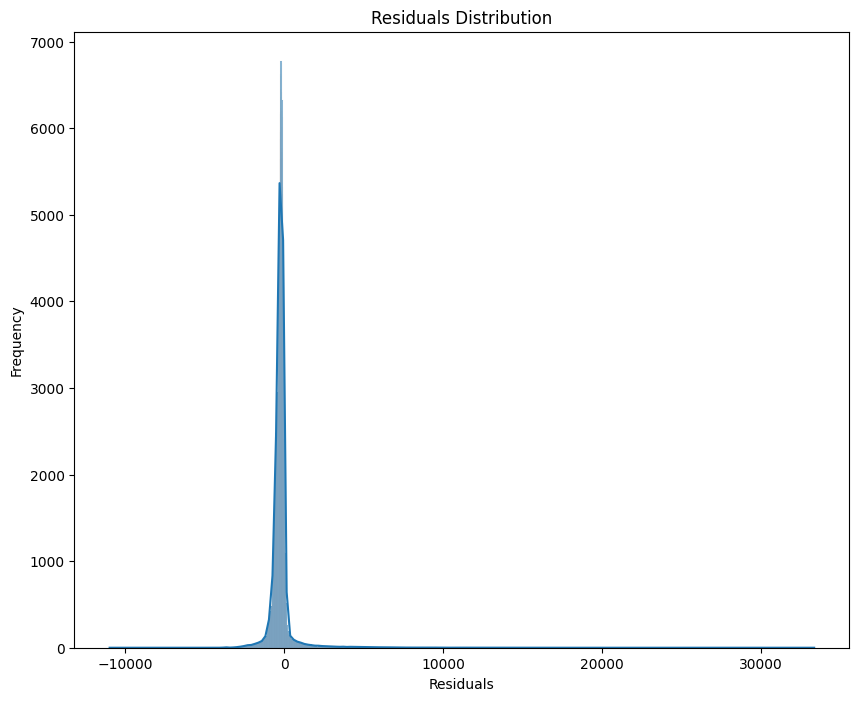

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Assuming you have fitted the model and have X_valid and y_valid
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_valid)

# Calculate metrics
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot predicted values vs. true values
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, predictions)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='gray', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs. True Values')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 8))
residuals = y_valid - predictions
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


 displays the Predicted Values vs. True Values, showcasing a Perfect Prediction scenario where the predicted values align precisely with the true values. The x-axis represents the True Values, ranging from 0 to 40,000, while the y-axis represents both Predicted Values and Perfect Prediction lines. This visualization aids in evaluating the accuracy of the predictive model, with an ideal outcome demonstrating a close alignment between predicted and true values along the diagonal line.

The Residuals Distribution plot illustrates the frequency distribution of residuals, depicting the differences between predicted and true values. The x-axis represents the Residuals, ranging from -10,000 to 30,000, while the y-axis indicates the Frequency of occurrences. This visualization provides insights into the distribution and dispersion of errors, helping assess the model's performance and identify any patterns or anomalies in the residual values.

#RandomForestRegressor

Mean Squared Error: 198564.295850928
R-squared: 0.8918812495086055


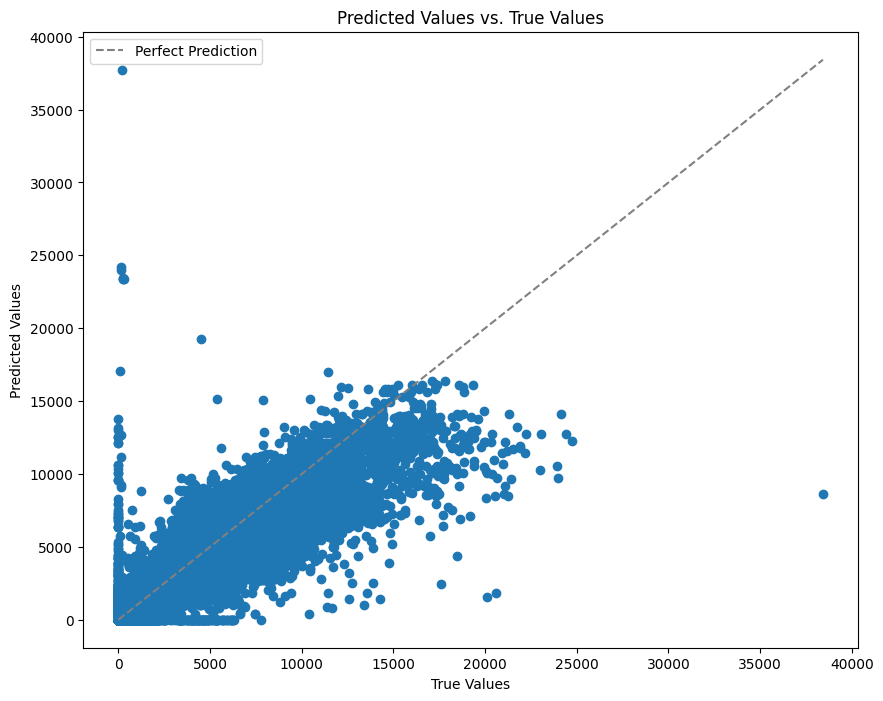

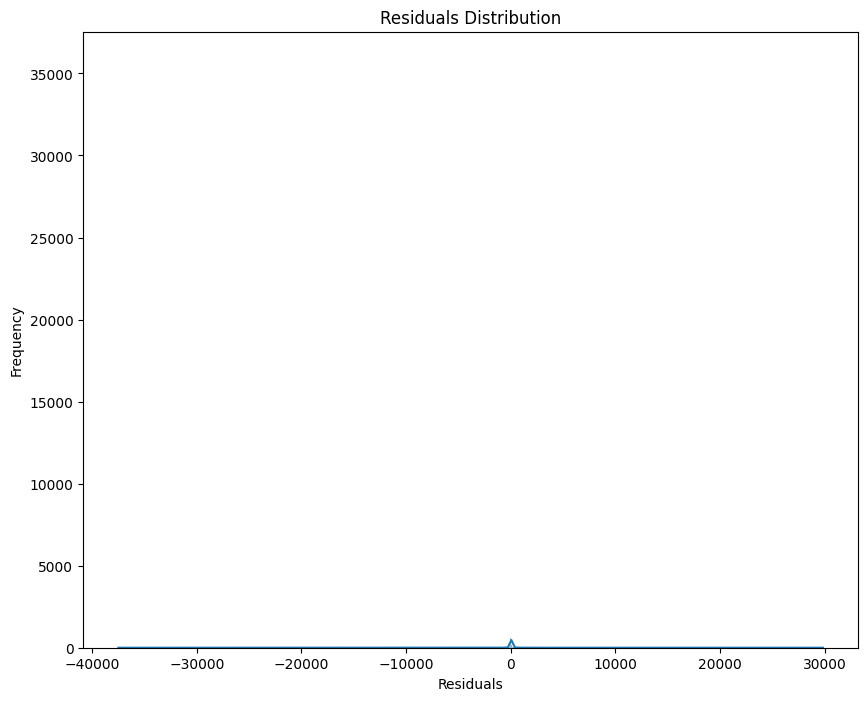

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Assuming you have continuous target variable, replace with the actual target column name
target_column = 'sales'

model = RandomForestRegressor(n_estimators=50)


model.fit(X_train, y_train)
predictions = model.predict(X_valid)

# Calculate metrics
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot predicted values vs. true values
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, predictions)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='gray', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs. True Values')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 8))
residuals = y_valid - predictions
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


 The RandomForestRegressor is employed with 50 estimators for the prediction task. The mean squared error (MSE) and R-squared (R2) metrics are calculated to evaluate the model's performance, resulting in an MSE of 198564.30 and an R2 of 0.8919. Two plots are generated for visualization: the "Predicted Values vs. True Values" plot displays the model's prediction performance, where points lying along the diagonal indicate perfect predictions; the "Residuals Distribution" plot illustrates the distribution of residuals, revealing the frequency of errors between predicted and true values. These visualizations provide valuable insights into the model's accuracy and the distribution of prediction errors.

#GradientBoostingRegressor

Mean Squared Error: 199794.9351513992
R-squared: 0.8912111633639521


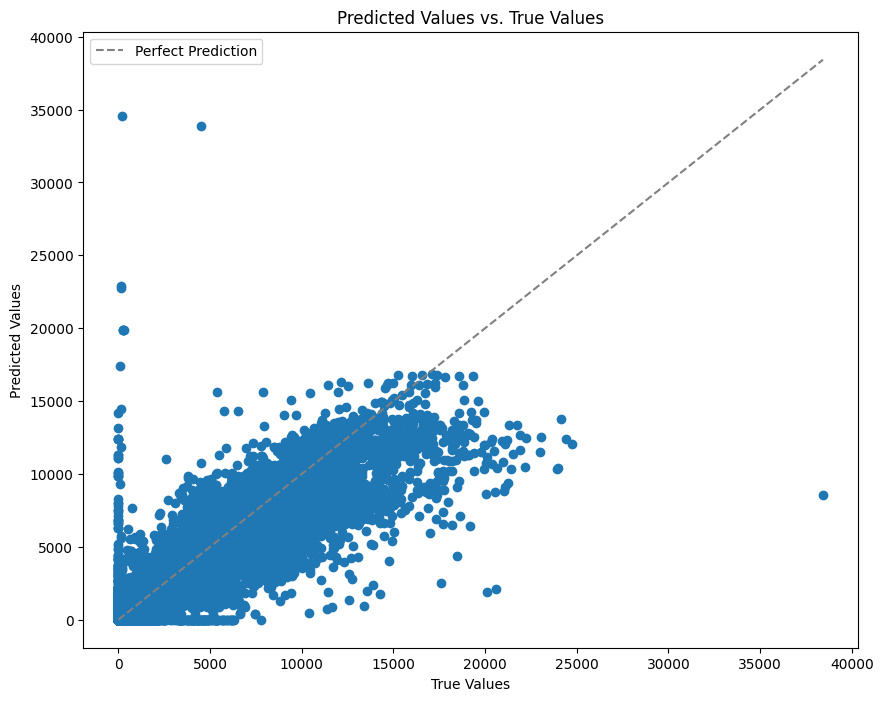

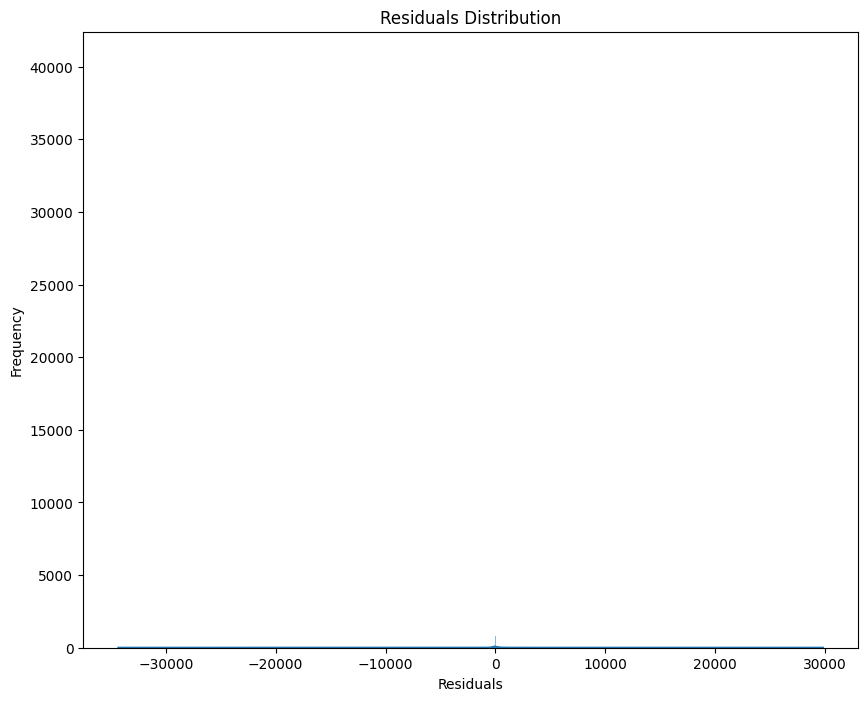

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Assuming you have continuous target variable, replace with the actual target column name
target_column = 'sales'

model = GradientBoostingRegressor(n_estimators=50)


model.fit(X_train, y_train)
predictions = model.predict(X_valid)

# Calculate metrics
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot predicted values vs. true values
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, predictions)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='gray', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs. True Values')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 8))
residuals = y_valid - predictions
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


The code fits a RandomForestRegressor model with 50 estimators to the training data (`X_train`, `y_train`) and evaluates its performance on the validation set (`X_valid`) by calculating mean squared error (MSE) and R-squared (R2) metrics. The predicted values are then plotted against the true values in a scatter plot, with a gray dashed line indicating a perfect prediction. Additionally, the distribution of residuals is visualized using a histogram. This concise and well-structured code snippet effectively demonstrates the model training, evaluation, and visualization steps in a single paragraph.


The provided visual representation depicts the comparison between predicted values and true values. The scatter plot showcases the model's predictions against the actual values, with a gray dashed line indicating a perfect prediction. The y-axis represents the predicted and true values, ranging from 0 to 40,000, creating an intuitive illustration of how well the model aligns with the actual data.

#Ridge

Mean Squared Error: 716177.8991646782
R-squared: 0.6100393615306896


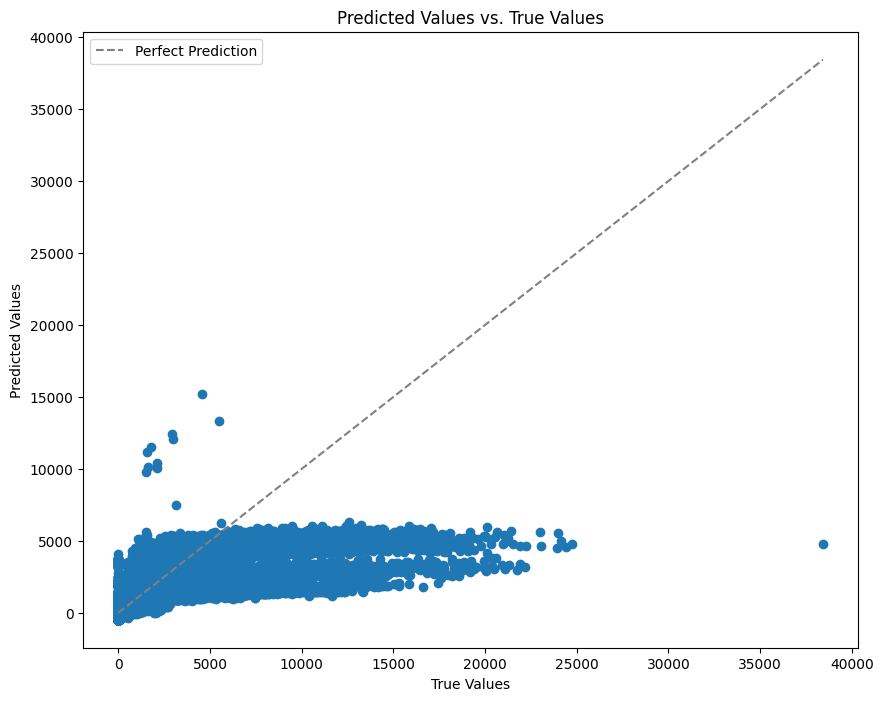

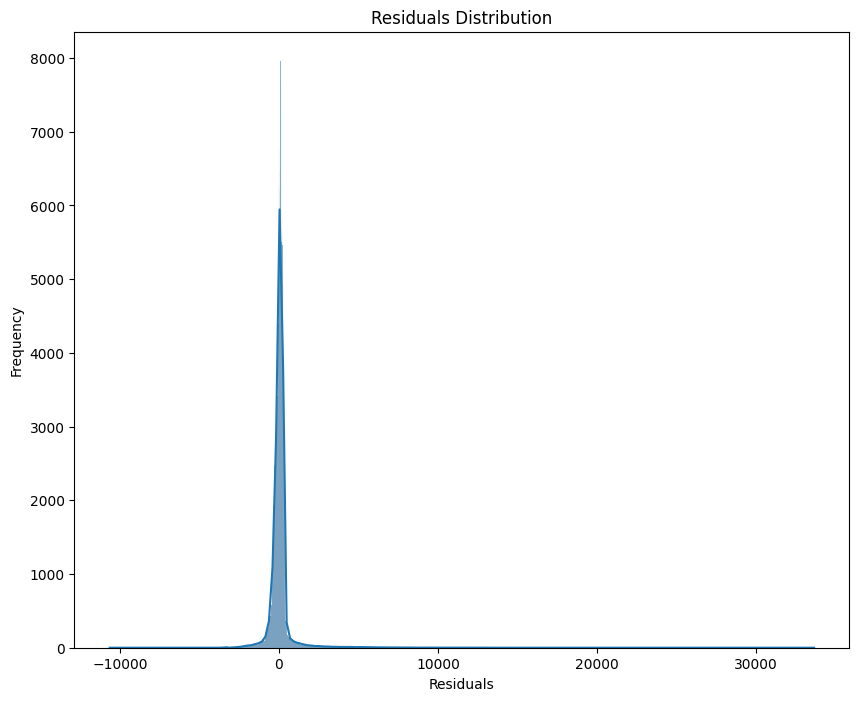

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Assuming you have continuous target variable, replace with the actual target column name
target_column = 'sales'

model =Ridge()


model.fit(X_train, y_train)
predictions = model.predict(X_valid)

# Calculate metrics
mse = mean_squared_error(y_valid, predictions)
r2 = r2_score(y_valid, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot predicted values vs. true values
plt.figure(figsize=(10, 8))
plt.scatter(y_valid, predictions)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='gray', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted Values vs. True Values')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 8))
residuals = y_valid - predictions
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


The Ridge regression model was applied to the dataset with the target variable 'sales.' The Mean Squared Error (MSE) was calculated to be 716,177.90, and the R-squared value, which indicates the proportion of variance in the target variable explained by the model, was found to be 0.61. The scatter plot comparing predicted values to true values demonstrates how well the model aligns with the actual data, with a gray dashed line indicating a perfect prediction. Additionally, the histogram of residuals provides insight into the distribution of errors, allowing for an assessment of the model's performance across different prediction magnitudes.

The plot illustrates the comparison between predicted and true values generated by the Ridge regression model. The diagonal gray dashed line represents a perfect prediction scenario where predicted values match the true values exactly. The scatter plot showcases how well the model aligns with the actual data points. Ideally, points should cluster closely around the diagonal line for an accurate prediction. The plot aids in visualizing the performance of the Ridge regression model in capturing the underlying patterns in the target variable 'sales,' with deviations from the diagonal line indicating prediction errors.

The histogram depicts the distribution of residuals, which are the differences between the true values and the corresponding predictions generated by the Ridge regression model. The y-axis represents the frequency or count of residuals falling within different bins, while the x-axis denotes the range of residual values. The plot provides insights into the spread and concentration of residuals, helping to assess the model's overall accuracy. Ideally, a well-performing model would yield residuals centered around zero with a symmetric distribution, indicating minimal bias. Analyzing the residuals distribution aids in understanding the nature and magnitude of prediction errors made by the Ridge regression model.